In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
PATH = "datasets/Kaggle_HPA_2018/"
data_path = Path(PATH)

In [4]:
NUM_CLASSES = 27
bs = 64
sz = [4,224,224]

In [5]:
# setting up a list of a random 20% of images in train as the validation set

lbl_csv = PATH + 'HPA_labels.csv'
n = len(list(open(lbl_csv))) -1
val_idxs = get_cv_idxs(n)

In [ ]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats, IntNorm=True)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [14]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):
    
    augs = [RandomDihedral()
           ]

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'train_all', lbl_csv, val_idxs = val_idxs, test_name='test_all', tfms=tfms, bs=bs, suffix = '.tiff')
    
    return data

In [16]:
# define augmentations
augs = [RandomDihedral()]

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

In [25]:
data.test_dl.dataset.__dict__.keys()

dict_keys(['y', 'src_idx', 'path', 'fnames', 'transform', 'n', 'c', 'sz', 'ch'])

### inpsect data_loaders

In [58]:
x, y = next(iter(data.trn_dl))

In [41]:
x_test, y_test = next(iter(data.test_dl))

In [59]:
to_np(y).shape

(64, 28)

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

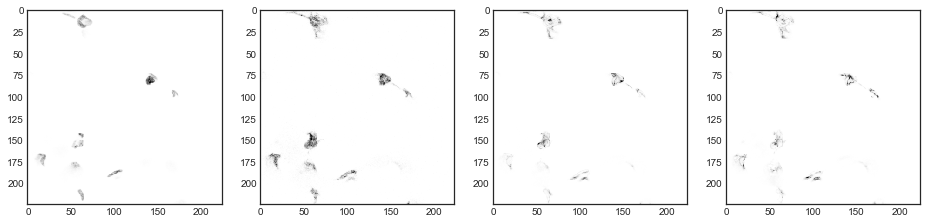

In [46]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [85]:
torch.cuda.is_available()

True

In [47]:
# base-model

arch = resnet18_c
learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=False)

In [48]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [49]:
learn.unfreeze()

In [50]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 4, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 12544)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 5

In [51]:
learn.lr_find()

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 312/389 [07:21<01:49,  1.42s/it, loss=0.867]

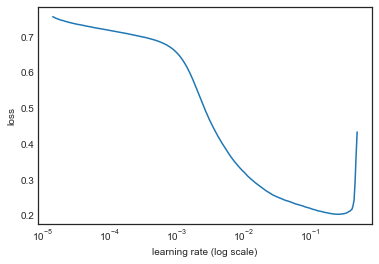

In [52]:
learn.sched.plot()

In [ ]:
# training loops:

In [53]:
%time learn.fit(1e-2, 1, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                                                      
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.151695   0.152329   0.948808   0.049758  
Wall time: 9min 50s


[array([0.15233]), 0.9488079909116538, 0.049758218066009004]

In [54]:
learn.save('first_model_1epoch')

In [ ]:
log_preds, y = learn.predict_with_targs()

## test-predictions

In [55]:
log_preds, y =  learn.predict_with_targs('test')

In [235]:
# creating submission file
thresh = 0.2



clss = np.arange(0, len(data.classes)) # get class indeces
res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > thresh)])) for p in log_preds]) # generating output

# ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
for i in range(res.shape[0]):
    if res[i] == '':
        res[i] = log_preds[i].argmax()

# getting image Ids
fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

# creating submission file
sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
sub_df.to_csv(f"{PATH}submissions/Test_submission_thresh_02.csv", index_label='Id')

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }